# Exploratory Data Analysis (Assignment # 4) - Team Forever Loop

**Authors:** Santosh Ganesan, Haran Nallasivan

**Date:** 23 September 2024

## Running this notebook

TODO: add instructions for running this notebook

## Introduction

The Welltory COVID-19 and Wearables Open Data Research [1] dataset contains a wealth of data from wearables worn by participants that both had and didn't have COVID-19. A problem that we were interested in exploring was predictability of COVID-19 symptoms based on this biometeric data. For this particular analysis, we're analyzing the effect size of presence of symptoms on blood pressure. The null hypothesis is that presence of symptoms has a negligible effect on the standard deviation of the systolic and diastolic blood pressure measurements.

As a control for this analysis, we will use the group of participants that didn't report symptoms.

## Data sourcing


In [1]:
# Import statements
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

Path('./data').mkdir(exist_ok=True)

# Helper function for extracting and persisting data
def extract_df(csv_name):
    '''
    Extracts dataframe from the data set given a CSV filename. Persists locally to avoid redudant network calls and unnecessary load on Github.

    Parameters:
        csv_name (str) - CSV filename, e.g. "blood_pressure"
    Returns:
        A pandas dataframe
    '''
    try:
        return pd.read_csv(f'./data/{csv_name}.csv')
    except:
        df = pd.read_csv(f'https://raw.githubusercontent.com/Welltory/hrv-covid19/refs/heads/master/data/{csv_name}.csv')
        df.to_csv(f'./data/{csv_name}.csv')
        return df

# Loaading the data frames
csv_names = ['blood_pressure', 'participants']
df = {}
for csv_name in csv_names:
    df[csv_name] = extract_df(csv_name)
df['blood_pressure'].head(2)

,Unnamed: 0,user_code,measurement_datetime,diastolic,systolic,functional_changes_index,circulatory_efficiency,kerdo_vegetation_index,robinson_index
0,0,01bad5a519,2020-04-29 22:33:33,100,150,NaN,NaN,NaN,NaN
1,1,01bad5a519,2020-04-30 01:33:33,100,150,NaN,NaN,NaN,NaN


## Questions we're asking

1. What are the dimensions of the dataset (number of rows and columns)?
1. What are the data types of the variables (numerical, categorical, text, etc.)?
1. Are there any missing values, and if so, how are they represented?

In [2]:
df['blood_pressure'].info()
print(f"Missing Values:\n{df['blood_pressure'].isnull().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                721 non-null    int64  
 1   user_code                 721 non-null    object 
 2   measurement_datetime      721 non-null    object 
 3   diastolic                 721 non-null    int64  
 4   systolic                  721 non-null    int64  
 5   functional_changes_index  299 non-null    float64
 6   circulatory_efficiency    299 non-null    float64
 7   kerdo_vegetation_index    283 non-null    float64
 8   robinson_index            299 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 50.8+ KB
Missing Values:
Unnamed: 0                    0
user_code                     0
measurement_datetime          0
diastolic                     0
systolic                      0
functional_changes_index    422
circulatory_efficien

In [3]:
df['participants'].info()
print(f"Missing Values:\n{df['participants'].isnull().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      185 non-null    int64  
 1   user_code       185 non-null    object 
 2   gender          185 non-null    object 
 3   age_range       185 non-null    object 
 4   city            173 non-null    object 
 5   country         179 non-null    object 
 6   height          183 non-null    float64
 7   weight          185 non-null    float64
 8   symptoms_onset  147 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 13.1+ KB
Missing Values:
Unnamed: 0         0
user_code          0
gender             0
age_range          0
city              12
country            6
height             2
weight             0
symptoms_onset    38
dtype: int64


### Interpretation

### Transformation to add `had_symptoms` column to participants

Here we want to add a new column dervied from `symptoms_onset` that more clearly describes whether or not the participant had symptoms.

In [4]:
df['participants']['had_symptoms'] = df['participants']['symptoms_onset'].apply(lambda x: 'Y' if pd.notnull(x) else 'N')
df['participants'].head(3)

,Unnamed: 0,user_code,gender,age_range,city,country,height,weight,symptoms_onset,had_symptoms
0,0,007b8190cf,m,25-34,Mandalay,Myanmar,170.18,96.162,NaN,N
1,1,013f6d3e5b,f,18-24,São Paulo,Brazil,174.00,77.300,5/15/2020,Y
2,2,01bad5a519,m,45-54,St Petersburg,Russia,178.00,92.000,4/5/2020,Y


### Transformation to add `timestamp` column to `blood_pressure`

Here we want to use the date-time strings to create a timestamp column of Pandas datetime objects.

In [5]:
df['blood_pressure']['timestamp'] = pd.to_datetime(df['blood_pressure']['measurement_datetime'])

### Joining the two datafames

We're joining the participant metadata dataframe into the blood pressure dataframe so that we can perform our analysis on a single denormalized table.

In [6]:
df['joined'] = pd.merge(df['blood_pressure'], df['participants'], on='user_code', how='left')
df['joined'].iloc[::10].head(10)

,Unnamed: 0_x,user_code,measurement_datetime,diastolic,systolic,functional_changes_index,circulatory_efficiency,kerdo_vegetation_index,robinson_index,timestamp,Unnamed: 0_y,gender,age_range,city,country,height,weight,symptoms_onset,had_symptoms
0,0,01bad5a519,2020-04-29 22:33:33,100,150,NaN,NaN,NaN,NaN,2020-04-29 22:33:33,2,m,45-54,St Petersburg,Russia,178.00,92.000,4/5/2020,Y
10,10,01bad5a519,2020-05-03 21:25:34,80,120,2.92,3800.0,16.0,114.00,2020-05-03 21:25:34,2,m,45-54,St Petersburg,Russia,178.00,92.000,4/5/2020,Y
20,20,01bad5a519,2020-05-11 20:15:55,80,118,NaN,NaN,NaN,NaN,2020-05-11 20:15:55,2,m,45-54,St Petersburg,Russia,178.00,92.000,4/5/2020,Y
30,30,1b9321b648,2020-04-19 21:28:27,85,115,NaN,NaN,NaN,NaN,2020-04-19 21:28:27,21,f,25-34,Kamyshlov,Russia,154.00,67.000,4/11/2020,Y
40,40,1ce1d77659,2020-05-12 14:21:59,75,121,2.45,3450.0,NaN,90.75,2020-05-12 14:21:59,22,m,25-34,Richmond Hill,United States,167.64,72.575,4/4/2020,Y
50,50,1ed25f66e9,2020-05-21 11:18:22,80,120,NaN,NaN,NaN,NaN,2020-05-21 11:18:22,23,m,25-34,Draveil,France,176.00,82.500,3/14/2020,Y
60,60,295ed96279,2020-01-06 09:24:51,70,110,2.10,2440.0,NaN,67.10,2020-01-06 09:24:51,34,m,35-44,Moscow,Russia,166.00,55.000,5/11/2020,Y
70,70,295ed96279,2020-01-18 10:36:20,65,105,NaN,NaN,NaN,NaN,2020-01-18 10:36:20,34,m,35-44,Moscow,Russia,166.00,55.000,5/11/2020,Y
80,80,425969dc69,2020-05-04 21:42:10,76,114,NaN,NaN,NaN,NaN,2020-05-04 21:42:10,51,f,35-44,London,United Kingdom,170.18,76.203,3/11/2020,Y
90,90,6be5033971,2020-04-15 19:53:36,80,131,NaN,NaN,NaN,NaN,2020-04-15 19:53:36,81,f,45-54,Kyiv,Ukraine,164.00,58.500,3/28/2020,Y


## Questions we're asking

1. What does this blood pressure data look like visually for users that reported symptoms versus users that didn't?
2. Are there any noticeable outliers?

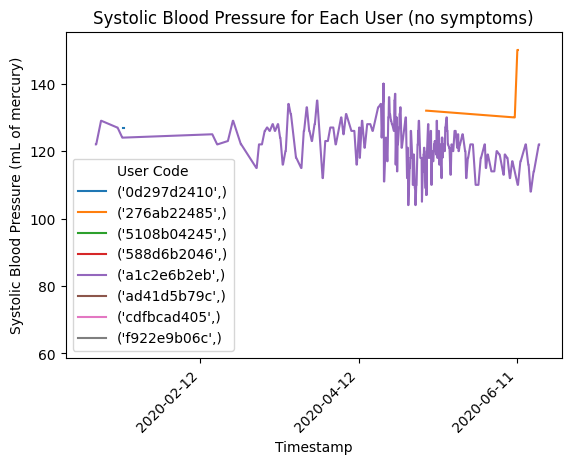

In [7]:
# Create a figure and axis
fig, ax = plt.subplots()

# Systolic blood pressure for participants who didn't report symptoms
for key, grp in df['joined'][df['joined']['had_symptoms'] == 'N'].groupby(['user_code']):
    ax.plot(grp['timestamp'], grp['systolic'], label=key)

# Format the x-axis to show dates at sensible intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add legend, title, and labels
ax.legend(title='User Code')
ax.set_title('Systolic Blood Pressure for Each User (no symptoms)')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Systolic Blood Pressure (mL of mercury)')

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)

# Show the plot
plt.show()


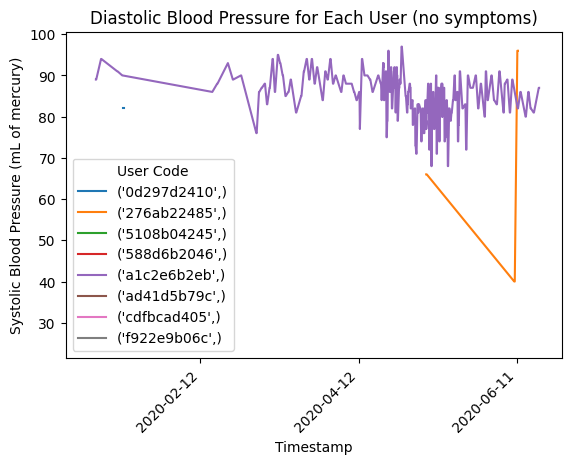

In [8]:
# Create a figure and axis
fig, ax = plt.subplots()

# Diastolic blood pressure for participants who didn't report symptoms
for key, grp in df['joined'][df['joined']['had_symptoms'] == 'N'].groupby(['user_code']):
    ax.plot(grp['timestamp'], grp['diastolic'], label=key)

# Format the x-axis to show dates at sensible intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add legend, title, and labels
ax.legend(title='User Code')
ax.set_title('Diastolic Blood Pressure for Each User (no symptoms)')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Diastolic Blood Pressure (mL of mercury)')

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)

# Show the plot
plt.show()

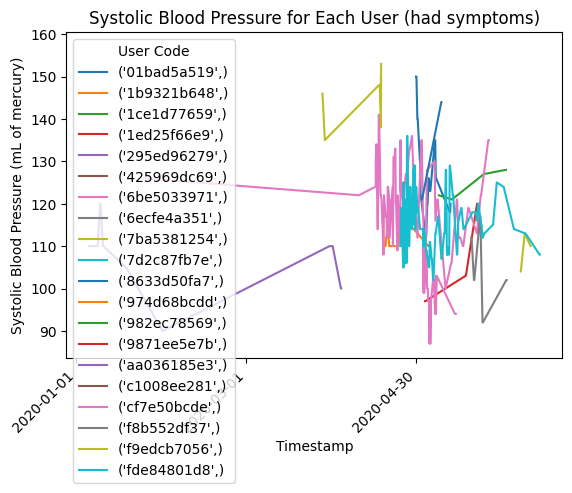

In [9]:
# Random sampling of user codes
sampled_user_codes = df['joined'][df['joined']['had_symptoms'] == 'Y']['user_code'].drop_duplicates().sample(n=20, random_state=1)

# Create a figure and axis
fig, ax = plt.subplots()

# Systolic blood pressure for sampled participants who reported having symptoms
for key, grp in df['joined'][df['joined']['user_code'].isin(sampled_user_codes)].groupby(['user_code']):
    ax.plot(grp['timestamp'], grp['systolic'], label=key)

# Format the x-axis to show dates at sensible intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add legend, title, and labels
ax.legend(title='User Code')
ax.set_title('Systolic Blood Pressure for Each User (had symptoms)')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Systolic Blood Pressure (mL of mercury)')

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)

# Show the plot
plt.show()


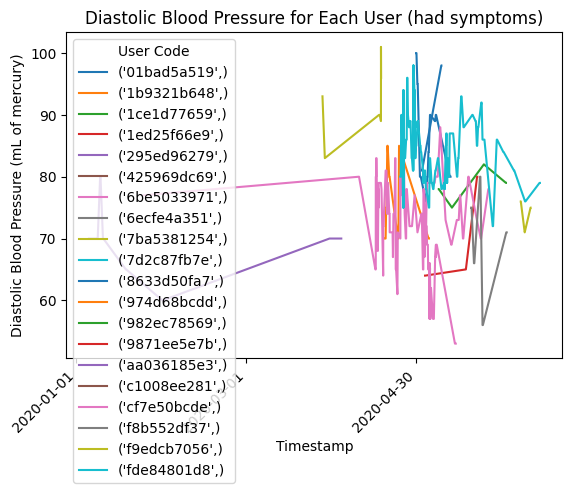

In [11]:
# Create a figure and axis
fig, ax = plt.subplots()

# Diastolic blood pressure for sampled participants who reported having symptoms
for key, grp in df['joined'][df['joined']['user_code'].isin(sampled_user_codes)].groupby(['user_code']):
    ax.plot(grp['timestamp'], grp['diastolic'], label=key)

# Format the x-axis to show dates at sensible intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add legend, title, and labels
ax.legend(title='User Code')
ax.set_title('Diastolic Blood Pressure for Each User (had symptoms)')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Diastolic Blood Pressure (mL of mercury)')

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)

# Show the plot
plt.show()

### Interpretation

## Questions we're asking

1) How should we sample the data?
2) Is there a correlation between systolic and diastolic standard deviations for both COVID and Control Groups?
3) Does this effect change after we remove outliers, duplicates, and null values?

### Identifying Missing values

TODO: Identifying time series with too few values as identified in previous data quality section




In [29]:
unique_values = df['joined']['user_code'].unique()
value_counts = df['joined']['user_code'].value_counts()
print("\nCount of each unique value in 'unique_values' column:\n", value_counts)



Count of each unique value in 'unique_values' column:
 user_code
a1c2e6b2eb    333
fde84801d8    128
6be5033971    105
cf7e50bcde     24
01bad5a519     23
295ed96279     22
1b9321b648     13
6ecfe4a351     10
7ba5381254      9
1ce1d77659      8
276ab22485      6
f9edcb7056      6
1ed25f66e9      6
8633d50fa7      4
0d297d2410      2
974d68bcdd      2
7d2c87fb7e      2
9871ee5e7b      2
588d6b2046      2
c1008ee281      2
f8b552df37      2
f922e9b06c      2
425969dc69      2
982ec78569      2
aa036185e3      1
ad41d5b79c      1
cdfbcad405      1
5108b04245      1
Name: count, dtype: int64


### Removing Missing values

TODO: Removing time series below a predetermined threshold

In [30]:
threshold = 3
filtered_df = df['joined'][df['joined']['user_code'].map(df['joined']['user_code'].value_counts()) >= threshold]
unique_values_f = filtered_df['user_code'].unique()
value_counts_f = filtered_df['user_code'].value_counts()
print("\nCount of each unique value in 'unique_values_f' column:\n", value_counts_f)


Count of each unique value in 'unique_values_f' column:
 user_code
a1c2e6b2eb    333
fde84801d8    128
6be5033971    105
cf7e50bcde     24
01bad5a519     23
295ed96279     22
1b9321b648     13
6ecfe4a351     10
7ba5381254      9
1ce1d77659      8
1ed25f66e9      6
276ab22485      6
f9edcb7056      6
8633d50fa7      4
Name: count, dtype: int64


### Handling outliers

TODO: remove outliers identified in previous data quality section



## Reference

[1] Pravdin, Pavel (2022). *Welltory COVID-19 and Wearables Open Data Research [dataset].* 22 July 2022. Welltory Inc. CC0-1.0 License. https://github.com/Welltory/hrv-covid19